In [1]:
%matplotlib inline

# Basic imports

In [2]:
from matplotlib import pyplot as plt

import subprocess
import glob
from scipy import stats
import pandas as pd
# import numpy as np
# import json
# from collections import defaultdict

# Configuration data for better plot customization


In [3]:
import matplotlib
###Default for jupyter display
matplotlib.rcParams['figure.dpi']= 150

matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['axes.labelsize'] = 10
matplotlib.rcParams['axes.titlesize'] = 10

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.8'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.bottom'] = True

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['font.weight']='normal'
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams['legend.fontsize'] = 10
# matplotlib.rcParams['text.usetex'] = True

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Notes:

There are a LOT of structure alignment tools (just like there are a lot of sequence alignment tools). So where to begin? Here I'm choosing two initially: one based on overall use / citations and speed (`TM-align`) and one based on the fact that it came out on top in a recent benchmark of method accuracy (`SP-alignNS`; see: https://link.springer.com/article/10.1007/s00239-020-09960-2). Are these two exhaustive? Of course not. Sufficient? Maybe. 

Note that there are a few other tools that we could consider using that I'm putting below in order of prioritize should we want to expand. 

1. `DaliLite` is an old and extremely well established (and well cited) program that is frequently updated. Just haven't gotten around to running it yet. Note that there are a number of links to older DALI versions with far more citations, I'm only listing the most recent paper from 2020 here.

    https://onlinelibrary.wiley.com/doi/full/10.1002/pro.3749 (download: http://ekhidna.biocenter.helsinki.fi/dali/)


2. `Deep-align` is a newer entrant into the field. Again, I simply haven't gotten around to it yet.

    https://www.nature.com/articles/srep01448 (download: https://github.com/realbigws/DeepAlign)


3. `Fr-TM-align` is seemingly close to `TM-align` in ideology but it is not particularly used / well-cited. It was easy to install and the output is nearly identical to `TM-align`, so (but for the fact that folks don't seem to use it) it's probably a better choice than `TM-align`. Overall, just doesn't seem too important given the availability of other software.

    https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-531 (download: http://cssb.biology.gatech.edu/skolnick/files/FrTMalign/index.html) 


4. `FAST` is pretty ancient but performed surprisingly well in the benchmark study. I couldn't really get it working quickly so might need to be compiled from source or tested on a different system. Or given the abundance of other tools, ignored.

    https://onlinelibrary.wiley.com/doi/abs/10.1002/prot.20331 (download: http://bu.wenglab.org/FAST/download.htm)
    


# Reading in dataframes from `QMEANDisCo` analyses

This was previously constructed separately in `structure_quality_assessment.ipynb`

In [4]:
full_df = pd.read_csv('../Results/QMEAN/full_results.tsv', sep='\t', index_col=0)
print(full_df.shape)
full_df.head()

(328, 6)


,protein,variant,template,model_number,source,qmeandisco_score
0,EFTU,1efc,NaN,model1,ITASSER,0.821203
1,EFTU,1efc,NaN,model2,ITASSER,0.812577
2,EFTU,Anc168,NaN,model1,ITASSER,0.807184
3,EFTU,Anc168,NaN,model2,ITASSER,0.787163
4,EFTU,Anc262,NaN,model1,ITASSER,0.818077


In [5]:
best_df = pd.read_csv('../Results/QMEAN/best_results.tsv', sep='\t', index_col=0)
print(best_df.shape)
best_df.head()

(54, 6)


,protein,variant,template,model_number,source,qmeandisco_score
34,EFTU,1efc,NaN,NaN,empirical,0.847527
0,EFTU,1efc,NaN,model1,ITASSER,0.821203
246,EFTU,1efc,NaN,model4,trRosetta,0.768104
35,EFTU,6gfu,NaN,NaN,empirical,0.845782
2,EFTU,Anc168,NaN,model1,ITASSER,0.807184


# Analyzing `modeller` results with different template file inputs

In [6]:
###Using empirical models as the reference case
###modern IF2 vs modern EFTU
reference_molecules = [('IF2', '3jcjF'), ('EFTU','1efc')]
reference_files = ['../Data/Structures/Template_structures/3jcjF.clean.pdb',
                   '../Data/Structures/Template_structures/1efc.clean.pdb']

###NOTE: select template here!
# template = '1zo1'
template = '3jcj'
# template = '3jcj_1efc'



model_source = 'modeller'
test_dirs = glob.glob('../Results/{}/*'.format(model_source))
test_dirs = sorted([i for i in test_dirs if 'IF2_Anc' in i])
if template == '1zo1':
    test_dirs = [i for i in test_dirs if 'Anc' == i[-6:-3]]
else:
    test_dirs = [i for i in test_dirs if template == i[-len(template):]]
print('Found {} directories of interest'.format(len(test_dirs)))
best_model_locs = []
for i in test_dirs:
    if 'Anc789' in i:###This wasn't in the original dataset so ommitting from analyses for now
        continue
    print(i)
    method = i.split('/')[-2]
    prot = i.split('/')[-1].split('_')[0]
    molecule = i.split('/')[-1].split('_')[1]
    print(method, prot, molecule)
    temp_df = full_df[(full_df['protein']==prot)&(full_df['variant']==molecule)&(full_df['source']==method)]
    temp_df = temp_df[temp_df['template']==template]
    temp_df.sort_values('qmeandisco_score', ascending=False)
    assert temp_df.shape[0]== 5
    model = temp_df.iloc[0]['model_number']
    file_loc = i + '/' + '{}.pdb'.format(model)
    best_model_locs.append(file_loc)
print('Test file locations:\n', best_model_locs)

Found 13 directories of interest
../Results/modeller/IF2_Anc520_3jcj
modeller IF2 Anc520
../Results/modeller/IF2_Anc536_3jcj
modeller IF2 Anc536
../Results/modeller/IF2_Anc550_3jcj
modeller IF2 Anc550
../Results/modeller/IF2_Anc558_3jcj
modeller IF2 Anc558
../Results/modeller/IF2_Anc622_3jcj
modeller IF2 Anc622
../Results/modeller/IF2_Anc670_3jcj
modeller IF2 Anc670
../Results/modeller/IF2_Anc702_3jcj
modeller IF2 Anc702
../Results/modeller/IF2_Anc719_3jcj
modeller IF2 Anc719
../Results/modeller/IF2_Anc743_3jcj
modeller IF2 Anc743
../Results/modeller/IF2_Anc750_3jcj
modeller IF2 Anc750
../Results/modeller/IF2_Anc754_3jcj
modeller IF2 Anc754
../Results/modeller/IF2_Anc788_3jcj
modeller IF2 Anc788
Test file locations:
 ['../Results/modeller/IF2_Anc520_3jcj/model1.pdb', '../Results/modeller/IF2_Anc536_3jcj/model1.pdb', '../Results/modeller/IF2_Anc550_3jcj/model1.pdb', '../Results/modeller/IF2_Anc558_3jcj/model1.pdb', '../Results/modeller/IF2_Anc622_3jcj/model1.pdb', '../Results/modeller/I

## Run `TM-align`

In [7]:
y_plot_dict = {}
x_plot_dict = {}
for metric in ['RMSD', 'TM-score']:
    y_plot_dict[metric] = {}
    
for reference_info, reference_file in zip(reference_molecules, reference_files):
    print('*** Reference file:', reference_file)
    ref_name = '_'.join(reference_info)
    rmsd_list = []
    tm_list = []
    labels = []
    for pdb_file in best_model_locs:
        print(pdb_file)
        with open('./temp.out', 'w') as outfile:
            subprocess.call('TMalign {} {}'.format(pdb_file, reference_file), stdout=outfile, shell=True)
        with open('./temp.out', 'r') as infile:
            for line in infile:
                if 'RMSD=' in line:
                    rmsd_list.append(float(line.split(',')[1].split('=')[-1]))
                if 'TM-score=' in line and 'Chain_2' in line:
                    tm_list.append(float(line.split('(')[0].split('=')[-1]))

        labels.append(pdb_file.split('/')[-2])
    y_plot_dict['RMSD'][ref_name] = rmsd_list
    y_plot_dict['TM-score'][ref_name] = tm_list
    x_plot_dict[ref_name] = labels

*** Reference file: ../Data/Structures/Template_structures/3jcjF.clean.pdb
../Results/modeller/IF2_Anc520_3jcj/model1.pdb
../Results/modeller/IF2_Anc536_3jcj/model1.pdb
../Results/modeller/IF2_Anc550_3jcj/model1.pdb
../Results/modeller/IF2_Anc558_3jcj/model1.pdb
../Results/modeller/IF2_Anc622_3jcj/model1.pdb
../Results/modeller/IF2_Anc670_3jcj/model1.pdb
../Results/modeller/IF2_Anc702_3jcj/model1.pdb
../Results/modeller/IF2_Anc719_3jcj/model1.pdb
../Results/modeller/IF2_Anc743_3jcj/model1.pdb
../Results/modeller/IF2_Anc750_3jcj/model1.pdb
../Results/modeller/IF2_Anc754_3jcj/model1.pdb
../Results/modeller/IF2_Anc788_3jcj/model1.pdb
*** Reference file: ../Data/Structures/Template_structures/1efc.clean.pdb
../Results/modeller/IF2_Anc520_3jcj/model1.pdb
../Results/modeller/IF2_Anc536_3jcj/model1.pdb
../Results/modeller/IF2_Anc550_3jcj/model1.pdb
../Results/modeller/IF2_Anc558_3jcj/model1.pdb
../Results/modeller/IF2_Anc622_3jcj/model1.pdb
../Results/modeller/IF2_Anc670_3jcj/model1.pdb
../Re

Comparison with IF2_3jcjF: SpearmanrResult(correlation=0.30069930069930073, pvalue=0.34225952894002465)
Comparison with EFTU_1efc: SpearmanrResult(correlation=0.20423041640915962, pvalue=0.5243243274359985)


IF2_3jcjF SpearmanrResult(correlation=-0.3356643356643357, pvalue=0.2861229029149875)
EFTU_1efc SpearmanrResult(correlation=-0.10489510489510491, pvalue=0.7456094809807079)


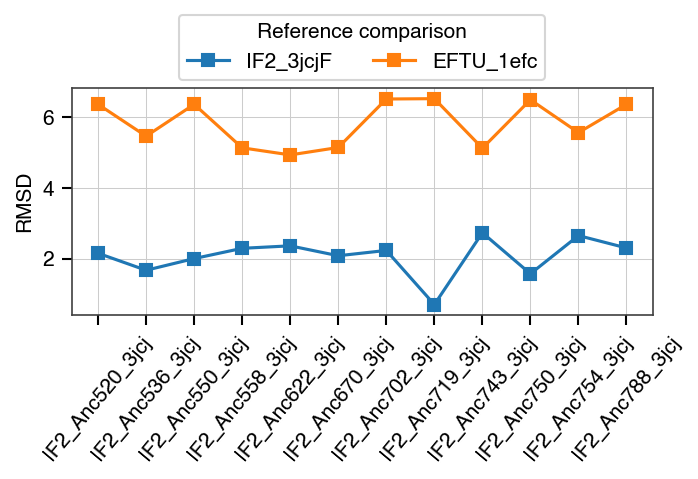

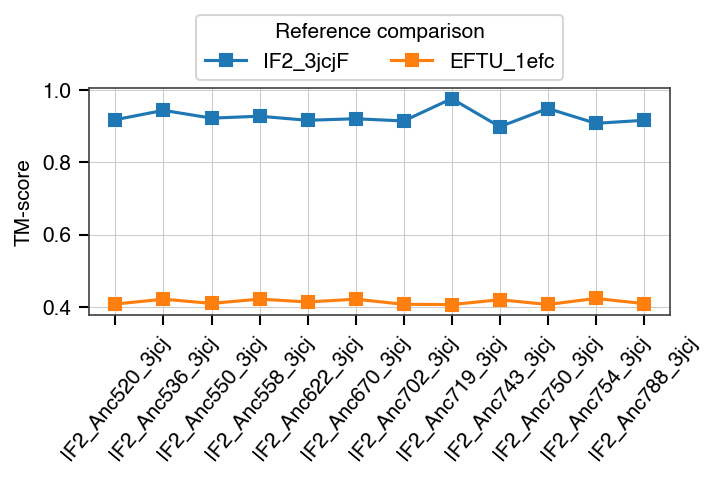

In [8]:
metric = 'RMSD'
fig, ax = plt.subplots(figsize=(5,2))
for key, vals in y_plot_dict[metric].items():
    ax.plot(vals, marker='s', label=key)
    print('Comparison with {}:'.format(key), stats.spearmanr(range(len(vals)), vals))
ax.set_xticks(range(len(best_model_locs)))
ax.set_xticklabels(x_plot_dict[list(x_plot_dict.keys())[0]], rotation=50);
ax.set_ylabel(metric)
ax.legend(title='Reference comparison', ncol=2, loc=9, bbox_to_anchor=(0.5, 1.37))
print()
print()
metric = 'TM-score'
fig, ax = plt.subplots(figsize=(5,2))
for key, vals in y_plot_dict[metric].items():
    ax.plot(vals, marker='s', label=key)
    print(key, stats.spearmanr(range(len(vals)), vals))
ax.set_xticks(range(len(best_model_locs)))
ax.set_xticklabels(x_plot_dict[list(x_plot_dict.keys())[0]], rotation=50);
ax.set_ylabel(metric)
ax.legend(title='Reference comparison', ncol=2, loc=9, bbox_to_anchor=(0.5, 1.37))

## Runnning `SPalign-NS`

In [9]:
y_plot_dict = {}
x_plot_dict = {}
for metric in ['RMSD', 'SP-score']:
    y_plot_dict[metric] = {}

for reference_info, reference_file in zip(reference_molecules, reference_files):
    print('Comparison with {}:'.format(reference_file))
    ref_name = '_'.join(reference_info)
    rmsd_list = []
    sp_list = []
    labels = []
    for pdb_file in best_model_locs:
        print(pdb_file)
        with open('./temp.out', 'w') as outfile:
            subprocess.call('~/workspace/SPalignNS/SPalignNS {} {}'.format(pdb_file, reference_file), stdout=outfile, shell=True)
        with open('./temp.out', 'r') as infile:
            for line in infile:
                if 'RMSD/Nali' in line:
                    rmsd_list.append(float(line.split('=')[1].split('/')[0]))
                if 'SP-score' in line:
                    sp_list.append(float(line.split(':')[1].split('(')[0]))


        labels.append(pdb_file.split('/')[-2])
        
    y_plot_dict['RMSD'][ref_name] = rmsd_list
    y_plot_dict['SP-score'][ref_name] = sp_list
    x_plot_dict[ref_name] = labels

Comparison with ../Data/Structures/Template_structures/3jcjF.clean.pdb:
../Results/modeller/IF2_Anc520_3jcj/model1.pdb
../Results/modeller/IF2_Anc536_3jcj/model1.pdb
../Results/modeller/IF2_Anc550_3jcj/model1.pdb
../Results/modeller/IF2_Anc558_3jcj/model1.pdb
../Results/modeller/IF2_Anc622_3jcj/model1.pdb


KeyboardInterrupt: 

IF2_3jcjF SpearmanrResult(correlation=-0.7762237762237763, pvalue=0.0029928636801859797)
EFTU_1efc SpearmanrResult(correlation=0.1776425927604834, pvalue=0.5807122554656803)


IF2_3jcjF SpearmanrResult(correlation=-0.10489510489510491, pvalue=0.7456094809807079)
EFTU_1efc SpearmanrResult(correlation=-0.2605698416254795, pvalue=0.41337102043327534)


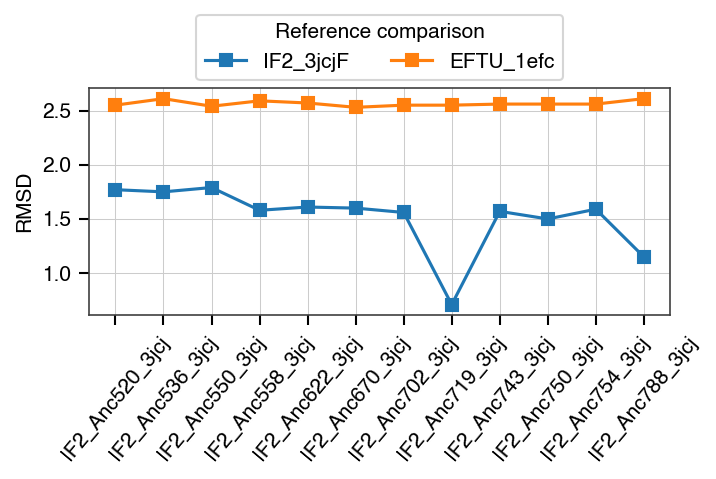

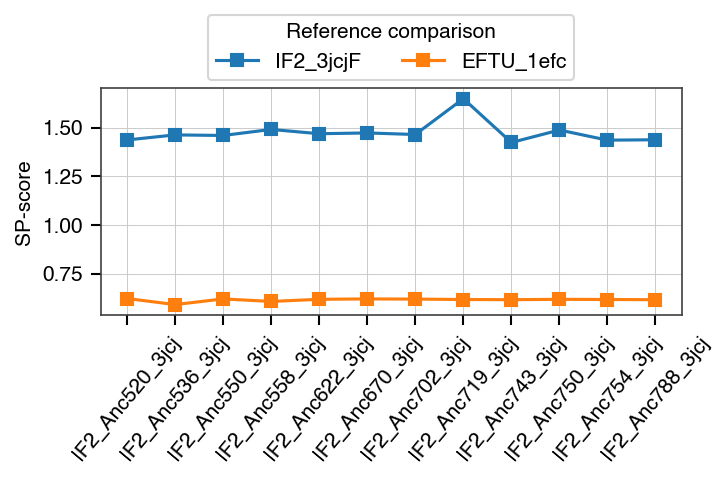

In [51]:
metric = 'RMSD'
fig, ax = plt.subplots(figsize=(5,2))
for key, vals in y_plot_dict[metric].items():
    ax.plot(vals, marker='s', label=key)
    print(key, stats.spearmanr(range(len(vals)), vals))
ax.set_xticks(range(len(best_model_locs)))
ax.set_xticklabels(x_plot_dict[list(x_plot_dict.keys())[0]], rotation=50);
ax.set_ylabel(metric)
ax.legend(title='Reference comparison', ncol=2, loc=9, bbox_to_anchor=(0.5, 1.37))
print()
print()
metric = 'SP-score'
fig, ax = plt.subplots(figsize=(5,2))
for key, vals in y_plot_dict['SP-score'].items():
    ax.plot(vals, marker='s', label=key)
    print(key, stats.spearmanr(range(len(vals)), vals))
ax.set_xticks(range(len(best_model_locs)))
ax.set_xticklabels(x_plot_dict[list(x_plot_dict.keys())[0]], rotation=50);
ax.set_ylabel(metric)
ax.legend(title='Reference comparison', ncol=2, loc=9, bbox_to_anchor=(0.5, 1.37))

# Selecting reference and comparison files
## First, select reference file/s that other structures will be compared with

A few options here as one might wish to compare structures to extant `IF2` and `EFTU` structures, or to ancestral `EFTU` and extant `EFTU`, or (my preferred approach) to *predictions* of extant `IF2` and `EFTU` structures (when possible), etc.

In [ ]:
###Using model predictions of empirical models as a reference case
# reference_molecules = [('IF2', '3jcjF'), ('EFTU','1efc')]
# reference_molecules = [('EFTU', 'Anc262'), ('EFTU','1efc')]
# reference_id = 'ITASSER'
# ###Gather exact reference file locations
# reference_files = []
# for protein, reference in reference_molecules:
#     best_model = df[(df['protein']==protein)&(df['variant']==reference)&(df['source']==reference_id)]
#     assert best_model.shape[0] == 1
#     best_model = best_model.iloc[0]['model_number']
#     reference_file_loc = '../Results/{}/{}_{}/{}.pdb'.format(reference_id, protein, reference, best_model)
#     reference_files.append(reference_file_loc)
# print(reference_files)


###Using empirical models as the reference case
###modern IF2 vs modern EFTU
reference_molecules = [('IF2', '3jcjF'), ('EFTU','1efc')]
reference_files = ['../Data/Structures/Template_structures/3jcjF.clean.pdb',
                   '../Data/Structures/Template_structures/1efc.clean.pdb']


###ancestral EFTU vs modern EFTU 
# reference_molecules = [('EFTU', '6gfu'), ('EFTU','1efc')]
# reference_files = ['../Data/Structures/Templates/6gfu.clean.pdb',
#                    '../Data/Structures/Templates/1efc.clean.pdb']
# print(reference_files)

## Test files (in a sorted order)

In [ ]:
model_source = 'ITASSER'
test_dirs = glob.glob('../Results/{}/*'.format(model_source))
test_dirs = sorted([i for i in test_dirs if 'IF2_Anc' in i])
best_model_locs = []
for i in test_dirs:
    print(i)
    method = i.split('/')[-2]
    prot = i.split('/')[-1].split('_')[0]
    molecule = i.split('/')[-1].split('_')[1]
    print(method, prot, molecule)
    temp_df = df[(df['protein']==prot)&(df['variant']==molecule)&(df['source']==method)]
    assert temp_df.shape[0]==1
    model = temp_df.iloc[0]['model_number']
    file_loc = i + '/' + '{}.pdb'.format(model)
    best_model_locs.append(file_loc)
print('Test file locations:\n', best_model_locs)

# `TM-align` 

It has >2000 citations, but is a bit old at this point and certainly not the most accurate approach. See:

https://academic.oup.com/nar/article/33/7/2302/2401364

Using this mostly as a quick and dirty approach. There is a server (https://zhanglab.ccmb.med.umich.edu/TM-align/) but I installed the stand alone package (and this code assumes that you have it installed as well). Instructions for download/installation are included on the server page.

In [ ]:
y_plot_dict = {}
x_plot_dict = {}
for metric in ['RMSD', 'TM-score']:
    y_plot_dict[metric] = {}
    
for reference_info, reference_file in zip(reference_molecules, reference_files):
    print('*** Reference file:', reference_file)
    ref_name = '_'.join(reference_info)
    rmsd_list = []
    tm_list = []
    labels = []
    for pdb_file in best_model_locs:
        print(pdb_file)
        with open('./temp.out', 'w') as outfile:
            subprocess.call('TMalign {} {}'.format(pdb_file, reference_file), stdout=outfile, shell=True)
        with open('./temp.out', 'r') as infile:
            for line in infile:
                if 'RMSD=' in line:
                    rmsd_list.append(float(line.split(',')[1].split('=')[-1]))
                if 'TM-score=' in line and 'Chain_2' in line:
                    tm_list.append(float(line.split('(')[0].split('=')[-1]))

        labels.append(pdb_file.split('/')[-2])
    y_plot_dict['RMSD'][ref_name] = rmsd_list
    y_plot_dict['TM-score'][ref_name] = tm_list
    x_plot_dict[ref_name] = labels

In [ ]:
metric = 'RMSD'
fig, ax = plt.subplots(figsize=(5,2))
for key, vals in y_plot_dict[metric].items():
    ax.plot(vals, marker='s', label=key)
    print('Comparison with {}:'.format(key), stats.spearmanr(range(len(vals)), vals))
ax.set_xticks(range(len(best_model_locs)))
ax.set_xticklabels(x_plot_dict[list(x_plot_dict.keys())[0]], rotation=50);
ax.set_ylabel(metric)
ax.legend(title='Reference comparison', ncol=2, loc=9, bbox_to_anchor=(0.5, 1.37))
print()
print()
metric = 'TM-score'
fig, ax = plt.subplots(figsize=(5,2))
for key, vals in y_plot_dict[metric].items():
    ax.plot(vals, marker='s', label=key)
    print(key, stats.spearmanr(range(len(vals)), vals))
ax.set_xticks(range(len(best_model_locs)))
ax.set_xticklabels(x_plot_dict[list(x_plot_dict.keys())[0]], rotation=50);
ax.set_ylabel(metric)
ax.legend(title='Reference comparison', ncol=2, loc=9, bbox_to_anchor=(0.5, 1.37))

# `SP-alignNS` - my (current) preferred choice

This program is not particularly well cited (https://academic.oup.com/bioinformatics/article/32/3/370/1743599, it built off of https://onlinelibrary.wiley.com/doi/abs/10.1002/prot.24100) but I'm a fan of benchmarks and in the large scale benchmarking test (see: https://link.springer.com/article/10.1007/s00239-020-09960-2) it performed as good or better than basically any program. It's not *fast* but not particularly slow either so I'm not saving results and just re-run the software to make the plots.

In [ ]:
y_plot_dict = {}
x_plot_dict = {}
for metric in ['RMSD', 'SP-score']:
    y_plot_dict[metric] = {}

for reference_info, reference_file in zip(reference_molecules, reference_files):
    print('Comparison with {}:'.format(reference_file))
    ref_name = '_'.join(reference_info)
    rmsd_list = []
    sp_list = []
    labels = []
    for pdb_file in best_model_locs:
        print(pdb_file)
        with open('./temp.out', 'w') as outfile:
            subprocess.call('~/workspace/SPalignNS/SPalignNS {} {}'.format(pdb_file, reference_file), stdout=outfile, shell=True)
        with open('./temp.out', 'r') as infile:
            for line in infile:
                if 'RMSD/Nali' in line:
                    rmsd_list.append(float(line.split('=')[1].split('/')[0]))
                if 'SP-score' in line:
                    sp_list.append(float(line.split(':')[1].split('(')[0]))


        labels.append(pdb_file.split('/')[-2])
        
    y_plot_dict['RMSD'][ref_name] = rmsd_list
    y_plot_dict['SP-score'][ref_name] = sp_list
    x_plot_dict[ref_name] = labels

In [ ]:
metric = 'RMSD'
fig, ax = plt.subplots(figsize=(5,2))
for key, vals in y_plot_dict[metric].items():
    ax.plot(vals, marker='s', label=key)
    print(key, stats.spearmanr(range(len(vals)), vals))
ax.set_xticks(range(len(best_model_locs)))
ax.set_xticklabels(x_plot_dict[list(x_plot_dict.keys())[0]], rotation=50);
ax.set_ylabel(metric)
ax.legend(title='Reference comparison', ncol=2, loc=9, bbox_to_anchor=(0.5, 1.37))
print()
print()
metric = 'SP-score'
fig, ax = plt.subplots(figsize=(5,2))
for key, vals in y_plot_dict['SP-score'].items():
    ax.plot(vals, marker='s', label=key)
    print(key, stats.spearmanr(range(len(vals)), vals))
ax.set_xticks(range(len(best_model_locs)))
ax.set_xticklabels(x_plot_dict[list(x_plot_dict.keys())[0]], rotation=50);
ax.set_ylabel(metric)
ax.legend(title='Reference comparison', ncol=2, loc=9, bbox_to_anchor=(0.5, 1.37))

# Comparing only extant structures

In [ ]:
query_files = ['../Data/Structures/Templates/3jcjF.clean.pdb',
              '../Data/Structures/Templates/6gfu.clean.pdb',
              '../Data/Structures/Templates/3jcjF.clean.pdb',
              '../Data/Structures/Templates/3jcjF.clean.pdb']
reference_files = ['../Data/Structures/Templates/1zo1.clean.pdb',
                  '../Data/Structures/Templates/1efc.clean.pdb',
                  '../Data/Structures/Templates/6gfu.clean.pdb',
                  '../Data/Structures/Templates/1efc.clean.pdb']
x_labels = ['3JCJ vs 1ZO1',
           '6GFU vs 1EFC',
           '3JCJ vs 6GFU',
           '3JCJ vs 1EFC']

rmsd_list = []
sp_list = []
for query_file, reference_file in zip(query_files, reference_files):
    with open('./temp.out', 'w') as outfile:
        subprocess.call('~/workspace/SPalignNS/SPalignNS {} {}'.format(query_file, reference_file), stdout=outfile, shell=True)
    with open('./temp.out', 'r') as infile:
        lines = infile.readlines()
    for line in lines:
        if 'RMSD/Nali' in line:
            rmsd_list.append(float(line.split('=')[1].split('/')[0]))
        if 'SP-score' in line:
            sp_list.append(float(line.split(':')[1].split('(')[0]))

In [ ]:
rmsd_list, sp_list

In [ ]:
metric = 'RMSD'
fig, ax = plt.subplots(figsize=(5,2))
for i, label in enumerate(x_labels):
    ax.bar(i+1, rmsd_list[i])
    
ax.set_xticks(range(1, len(x_labels)+1))
ax.set_xticklabels(x_labels, rotation=50);
ax.set_ylabel(metric)
ax.set_ylim(0, 4)
ax.set_xlim(0,5)

metric = 'SP-score'
fig, ax = plt.subplots(figsize=(5,2))
for i, label in enumerate(x_labels):
    ax.bar(i+1, sp_list[i])
ax.set_xticks(range(1, len(x_labels)+1))
ax.set_xticklabels(x_labels, rotation=50);
ax.set_ylabel(metric)
ax.set_ylim(0, 1.75)
ax.set_xlim(0,5)

# Scratch

Use FastSP score to quickly and easily compare reference alignments: https://academic.oup.com/bioinformatics/article/27/23/3250/234345

Code available after some searching here: https://sites.google.com/eng.ucsd.edu/datasets/alignment/fastsp

**Run a quick structure alignment**

In [ ]:
query_file = '../Data/Structures/Templates/3jcjF.clean.pdb'
reference_file = '../Data/Structures/Templates/1efc.clean.pdb'


with open('./temp.out', 'w') as outfile:
    subprocess.call('~/workspace/SPalignNS/SPalignNS {} {}'.format(query_file, reference_file), stdout=outfile, shell=True)
with open('./temp.out', 'r') as infile:
    lines = infile.readlines()
struct_if = lines[-3].split(' ')[-2]
struct_eftu = lines[-1].split(' ')[-2]
print('\n', struct_if, '\n\n', struct_eftu)

# with open('./temp.out', 'w') as outfile:
#     subprocess.call('TMalign {} {}'.format(query_file, reference_file), stdout=outfile, shell=True)
# with open('./temp.out', 'r') as infile:
#     lines = infile.readlines()
# struct_if = lines[-5].strip()
# struct_eftu = lines[-3].strip()
# print('\n', struct_if, '\n\n', struct_eftu)

**Extract *E. coli* sequences from the larger sequence alignment**

In [ ]:
aln_seq_a = list(SeqIO.parse('../Data/AJH/combined_group_fast.aln', 'fasta'))
for i, seq in enumerate(aln_seq_a):
    if 'ECOLI' in seq.id:
        print(i, seq.id)
seq_if_temp = str(aln_seq_a[243].seq)
seq_eftu_temp = str(aln_seq_a[592].seq)
seq_if = seq_if_temp
seq_eftu = seq_eftu_temp
# seq_if = ''.join([i for i,j in zip(seq_if_temp, seq_eftu_temp) if i+j != '--'])
# seq_eftu = ''.join([j for i,j in zip(seq_if_temp, seq_eftu_temp) if i+j != '--'])
print('****************')
print(seq_if)
print()
print(seq_eftu)

In [ ]:
print(len(struct_if), len(struct_eftu), len(seq_if), len(seq_eftu))

**Slice from the beginning to the end of the sequences**

In [ ]:
# new_index = 35 ###For "fast"
# new_index = 37 ###For "linsi"
new_index = 33 ###For "ginsi"
# seq_if = seq_if[new_index:]
# seq_eftu = seq_eftu[new_index:]

In [ ]:
# print(struct_if[:60])
# print()
# print(struct_eftu[:60])
# print()
# print()
# print()
# print(seq_if[:60])
# print()
# print(seq_eftu[:60])
######################
print(struct_if[:])
print()
print(struct_eftu[:])
print()
print()
print()
print(seq_if[:])
print()
print(seq_eftu[:])

In [ ]:
struct_if_indices = []
struct_eftu_indices = []
if_counter = 0
eftu_counter = 0
for i, j in zip(struct_if, struct_eftu):
    if i != '-':
        struct_if_indices.append(if_counter)
        struct_eftu_indices.append(eftu_counter)
        if_counter += 1
    if j != '-':
        eftu_counter += 1
        
seq_if_indices = []
seq_eftu_indices = []
if_counter = 0
eftu_counter = -7
for i, j in zip(seq_if, seq_eftu):
    if i != '-':
        seq_if_indices.append(if_counter)
        seq_eftu_indices.append(eftu_counter)
        if_counter += 1
    if j != '-':
        eftu_counter += 1

In [ ]:
print(struct_eftu_indices)

In [ ]:
print(seq_eftu_indices)

In [ ]:
hits = 0
possible = 0
for i in range(min([len(seq_eftu_indices), len(struct_eftu_indices)])):
    if seq_eftu_indices[i] == struct_eftu_indices[i]:
        hits += 1
    possible += 1
print(hits, possible)

In [ ]:
hits = 0
possible = 0
for i in range(min([len(seq_if_indices), len(struct_if_indices)])):
    if seq_if_indices[i] == struct_if_indices[i]:
        hits += 1
    possible += 1
print(hits, possible)

**Now remove gaps from index lists according to the respective IF alignments**

In [ ]:
matches = 0
for i, ns in enumerate(zip(seq_eftu, struct_eftu)):
    a, b = ns
    if a == b:
        matches += 1
print(matches)

In [ ]:
query_file = '../Data/Structures/Templates/1efc.clean.pdb'
reference_file = '../Data/Structures/Templates/6gfu.clean.pdb'
with open('./temp.out', 'w') as outfile:
    subprocess.call('~/workspace/SPalignNS/SPalignNS {} {}'.format(query_file, reference_file), stdout=outfile, shell=True)
    with open('./temp.out', 'r') as infile:
        lines = infile.readlines()
    for line in lines:
        if 'RMSD/Nali' in line:
            print(line)
        if 'SP-score' in line:
            print(line)